In [56]:
%load_ext autoreload
%autoreload 2

import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf
import sys
code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)
from math import radians, cos, sin, asin, sqrt
from onoffgpf import OnOffSVGP, OnOffLikelihood

import pickle

from math import radians, cos, sin, asin, sqrt

import copy
import sys

import geopandas as gpd
import numpy as np

import gpflow


code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

code_dir = '/cluster/home/kheuto01/code/opioid-overdose-models/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffSVGPPoiMC, OnOffLikelihood
gpflow.config.default_float()


from zinf_gp.metrics import normcdf, fixed_top_X

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable


import matplotlib
matplotlib.style.use('default')
font = {
        'size'   : 22}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

data_dir='/cluster/tufts/hugheslab/datasets/NSF_OD/results_20220606_update/'

In [3]:
file_name = f'clean_quarter_tract'
data_path = os.path.join(data_dir, file_name)
data_gdf = gpd.read_file(data_path)

In [5]:
geography_col='geoid'
timestep_col='timestep'
outcome_col='deaths'
test_years = 2
x_idx_cols = [geography_col, 'lat','lon', timestep_col,
      'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
      'svi_pctile',
      'neighbor_t', 'self_t-1']
y_idx_cols = [geography_col, timestep_col, outcome_col]
features_only = ['lat','lon', timestep_col,
                 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                 'svi_pctile',
                 'neighbor_t', 'self_t-1']

last_train_year = 2018
train_x_qtr = data_gdf[(data_gdf['year'] <= last_train_year)][x_idx_cols]

train_y_qtr = data_gdf[(data_gdf['year'] <= last_train_year)][y_idx_cols]

all_y_qtr = data_gdf[y_idx_cols]
test_x_qtr = data_gdf[(data_gdf['year'] > last_train_year) &
                  (data_gdf['year'] <= last_train_year+test_years)][x_idx_cols]

test_y = data_gdf[(data_gdf['year'] > last_train_year) &
                  (data_gdf['year'] <= last_train_year+test_years)][y_idx_cols]
starting_y_timestep = int(test_y[timestep_col].min())

In [12]:
K = 100
D = len(train_y_qtr.geoid.unique())

In [19]:

train_thresholds = train_y_qtr.groupby(['timestep']).quantile(1-K/D)

/tmp/ipykernel_31221/1929475534.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  train_thresholds = train_y_qtr.groupby(['timestep']).quantile(1-K/D)


In [20]:
train_thresholds

,deaths
timestep,
0.0,0.0
1.0,0.0
2.0,0.0
3.0,0.0
4.0,0.0
...,...
71.0,1.0
72.0,1.0
73.0,1.0


/tmp/ipykernel_31221/2591592152.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


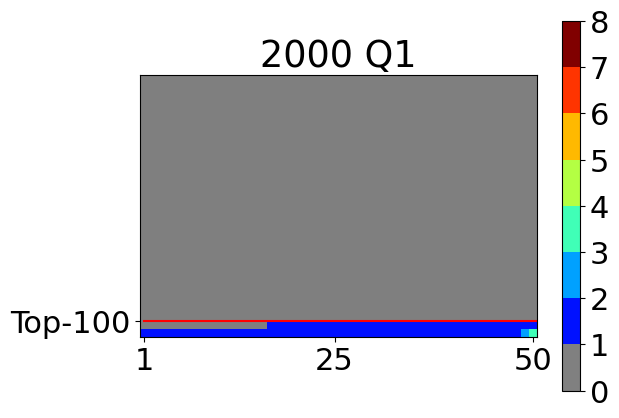

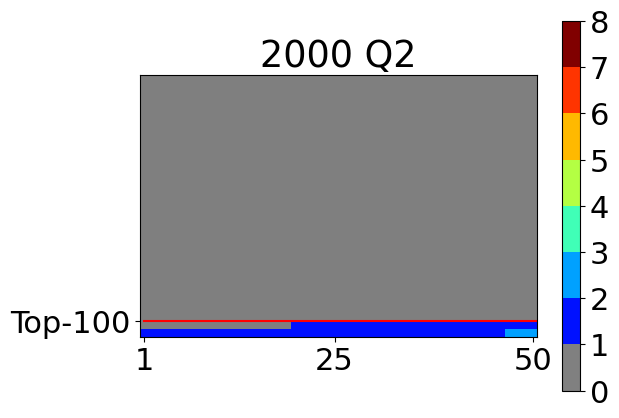

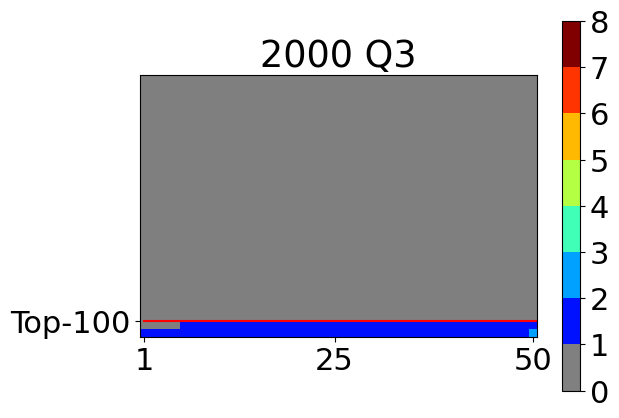

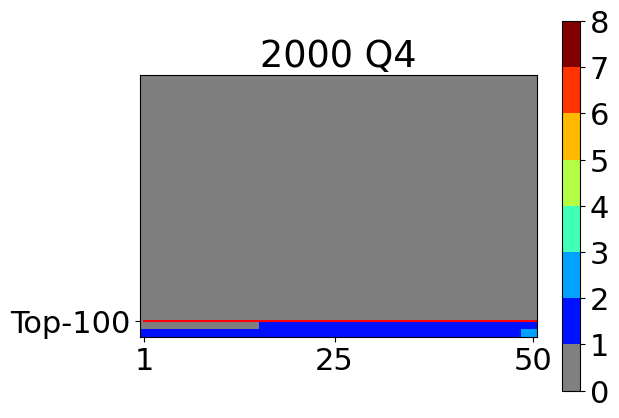

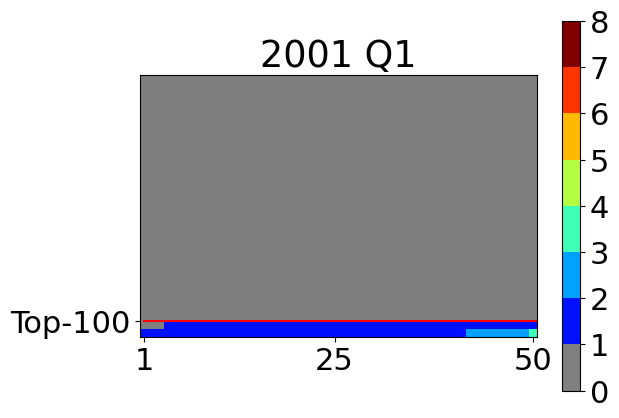

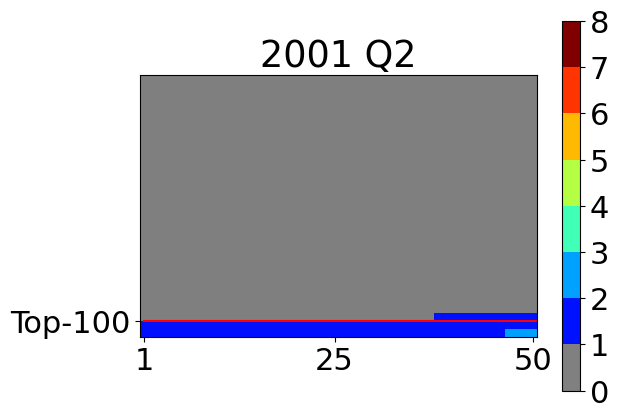

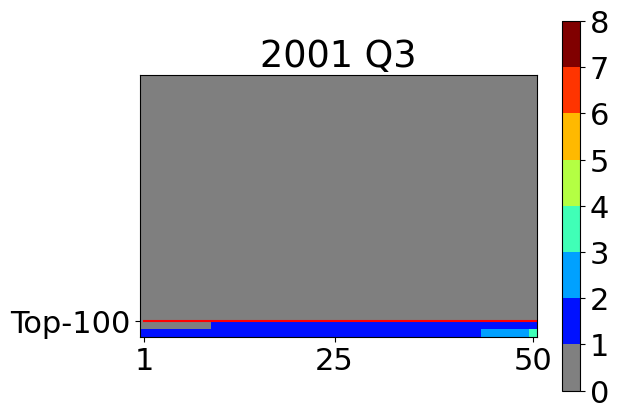

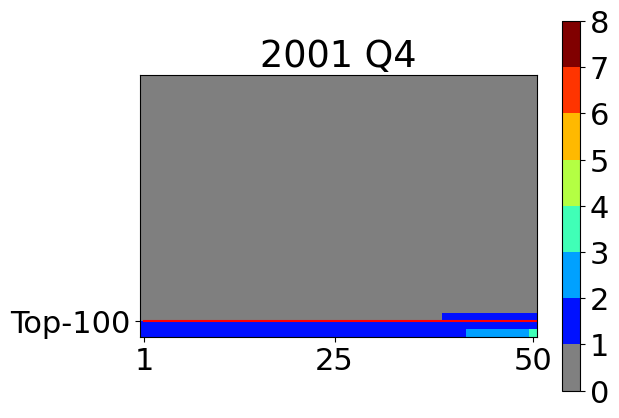

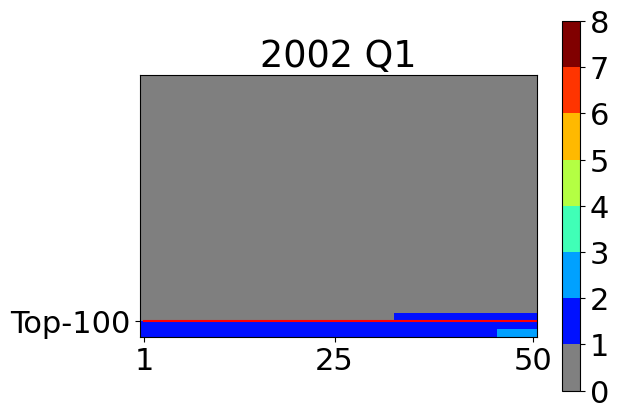

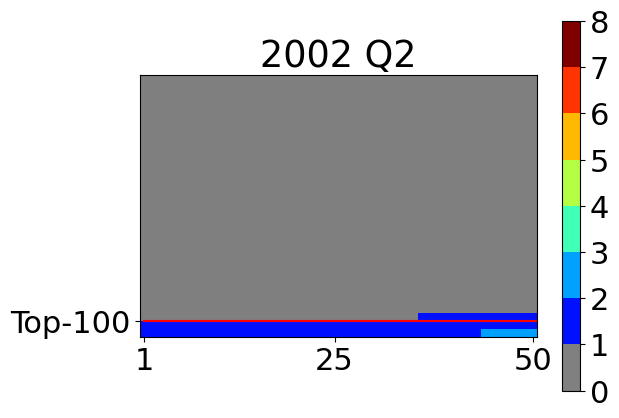

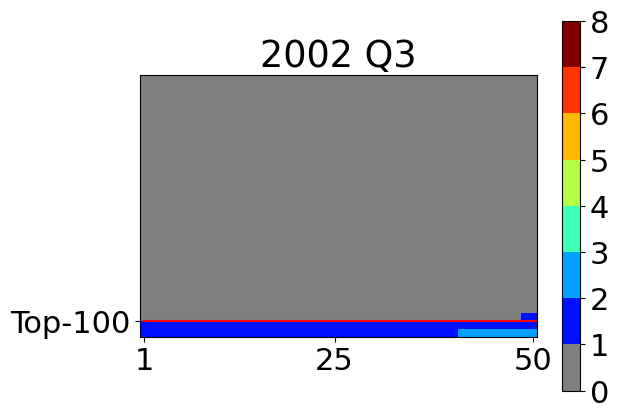

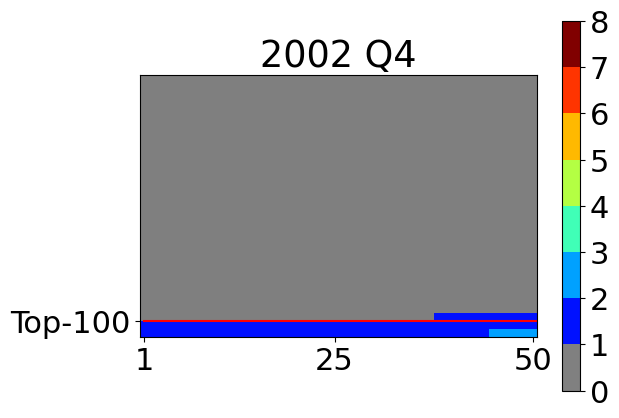

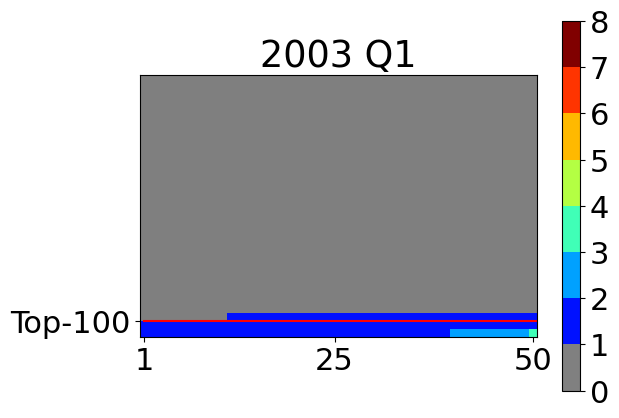

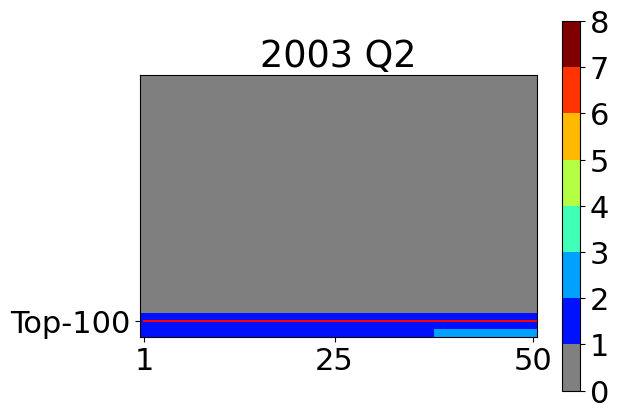

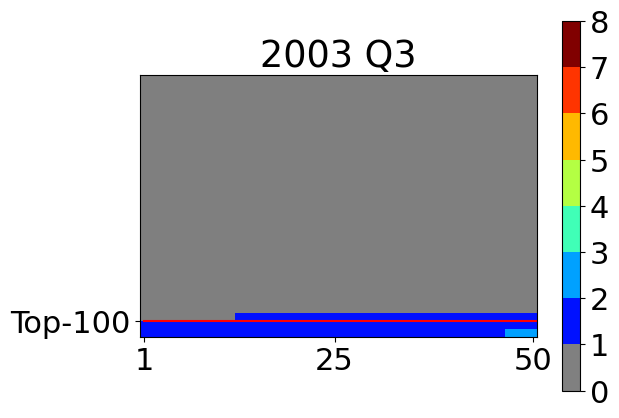

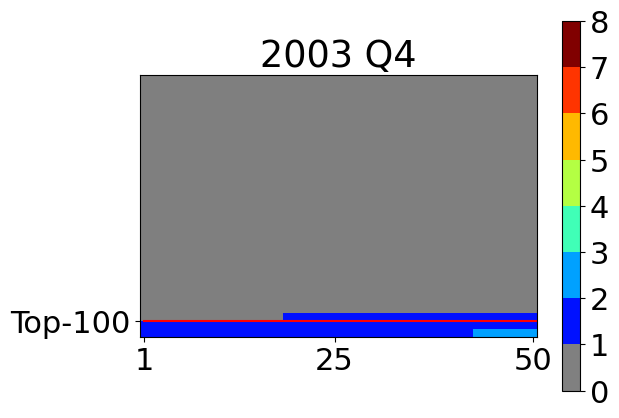

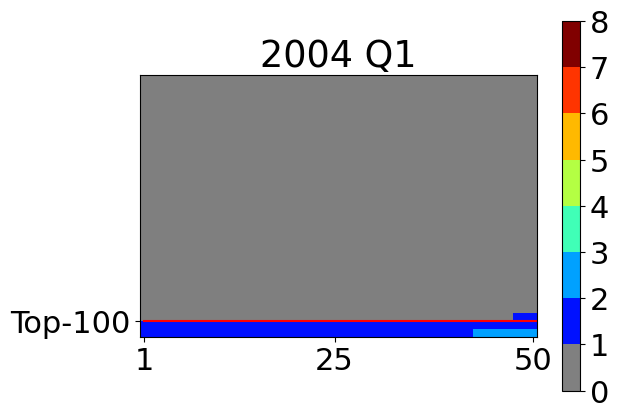

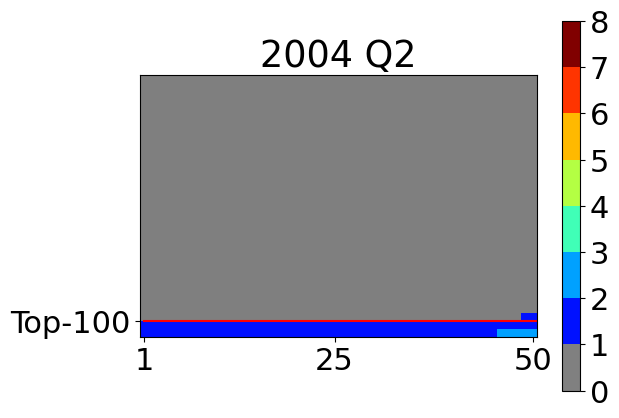

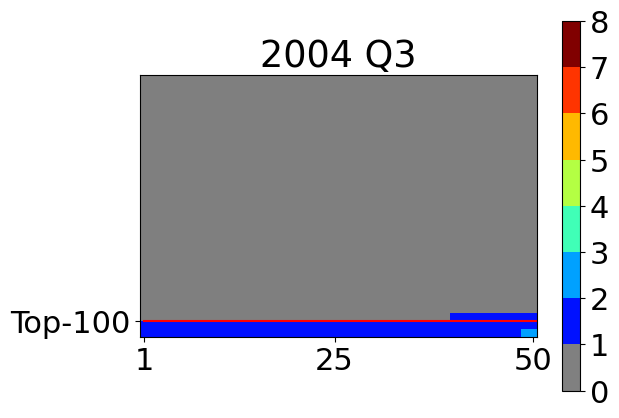

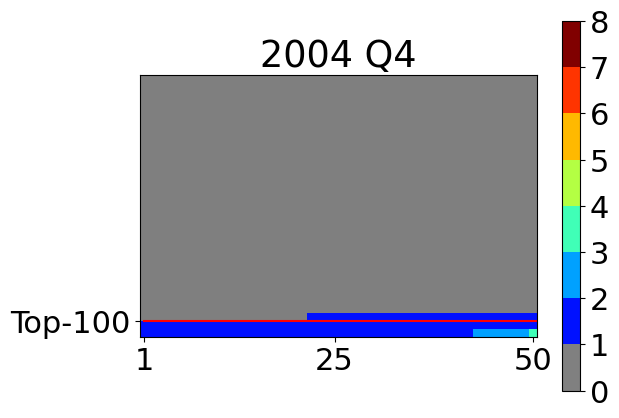

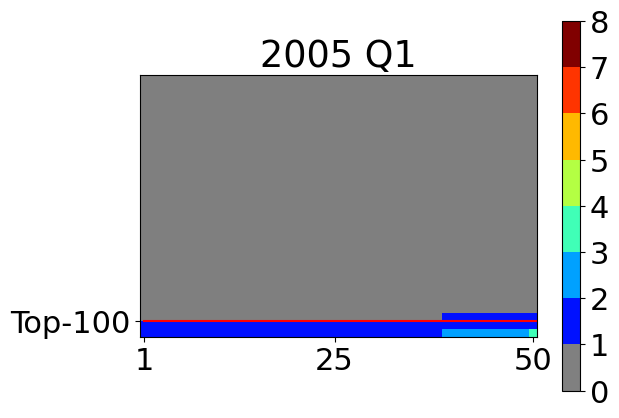

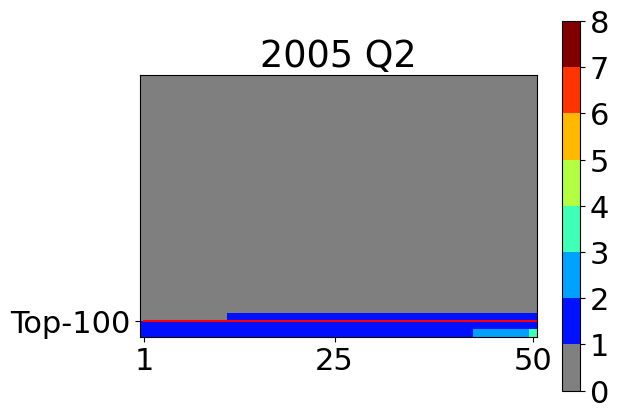

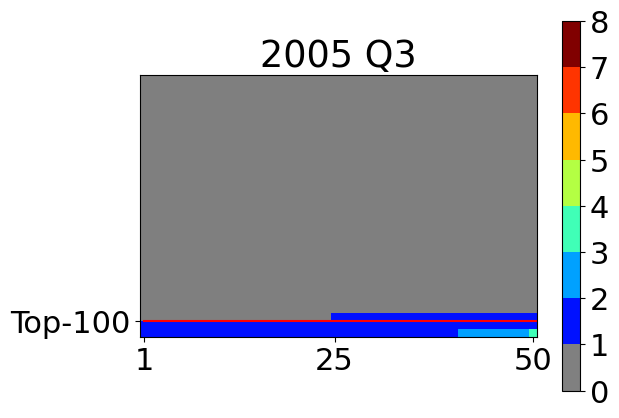

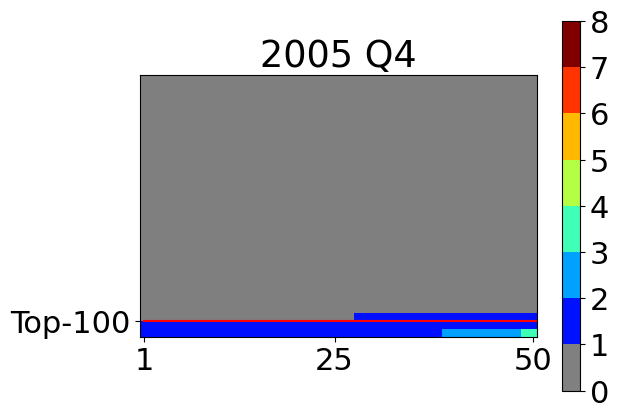

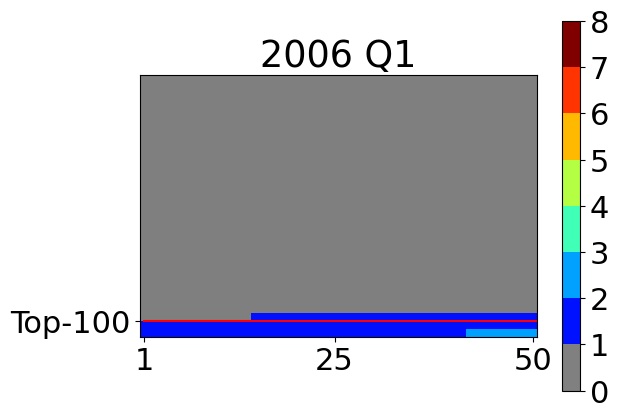

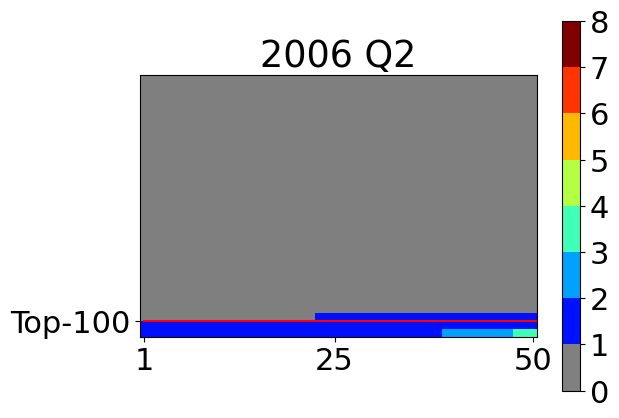

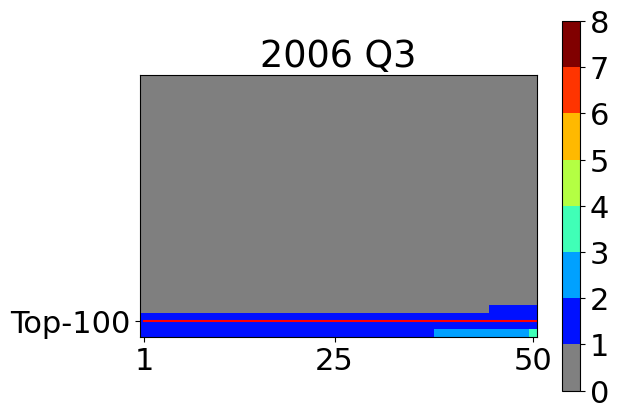

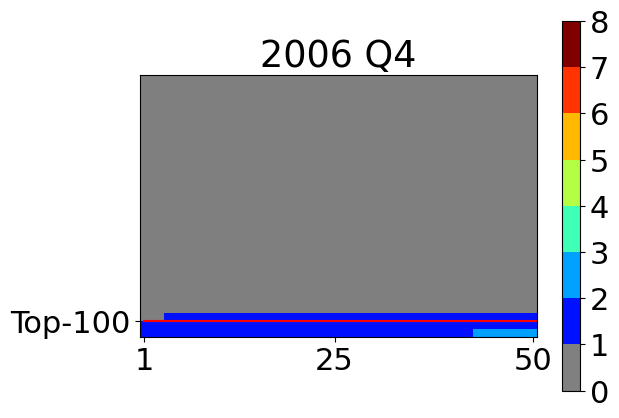

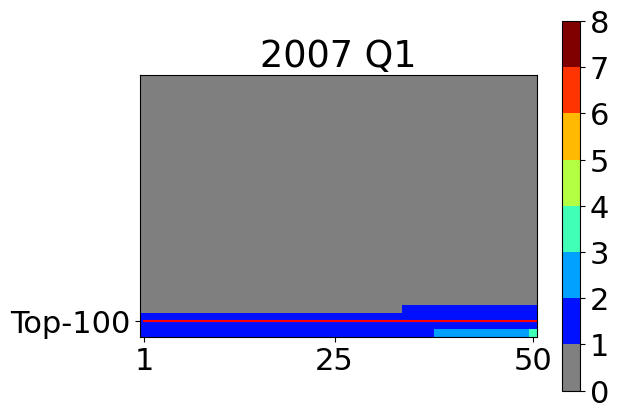

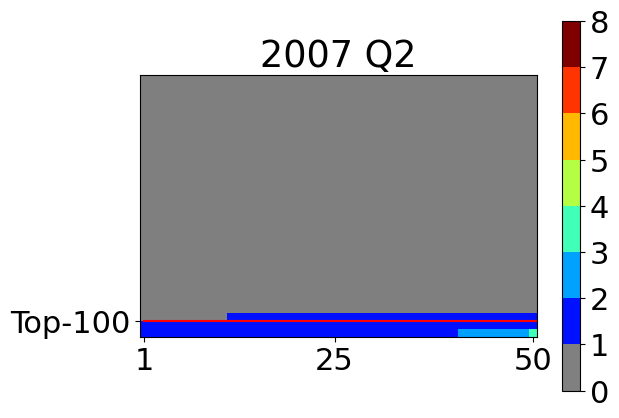

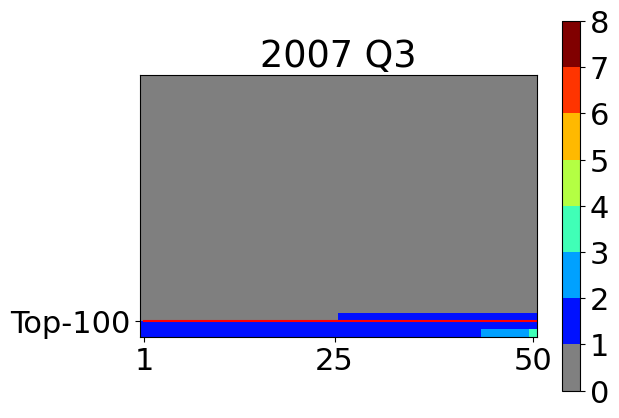

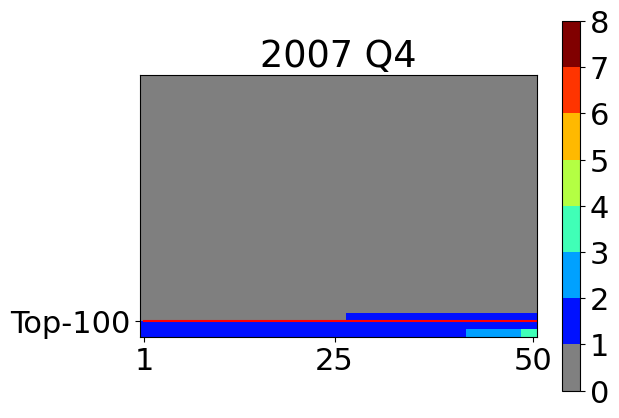

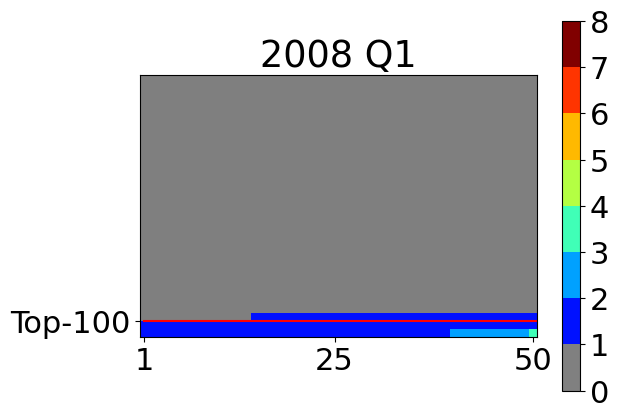

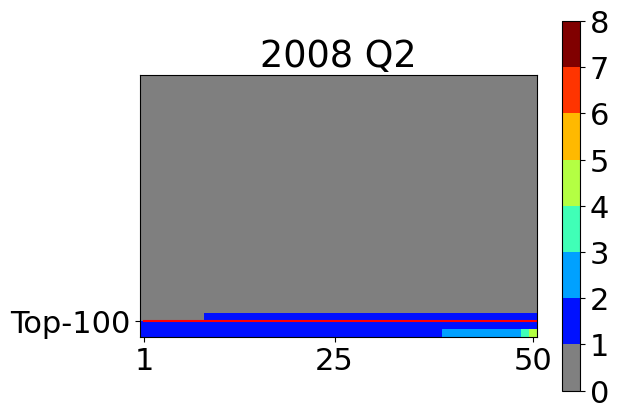

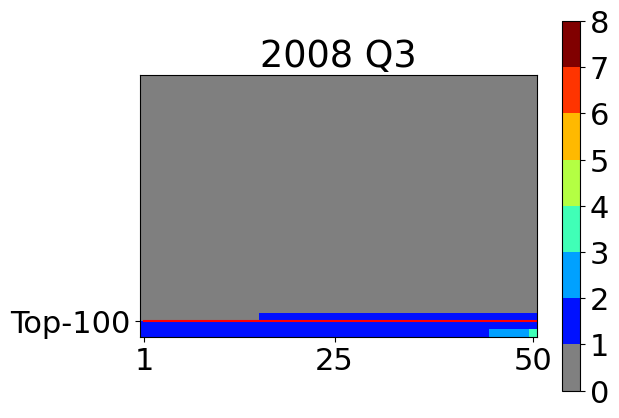

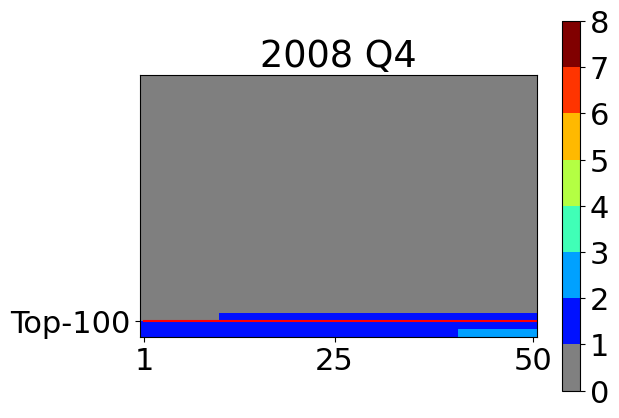

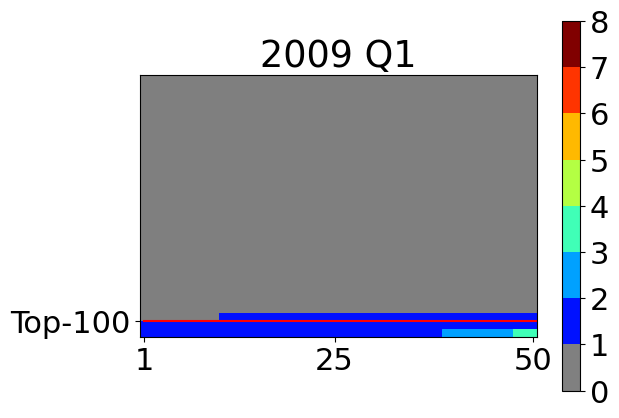

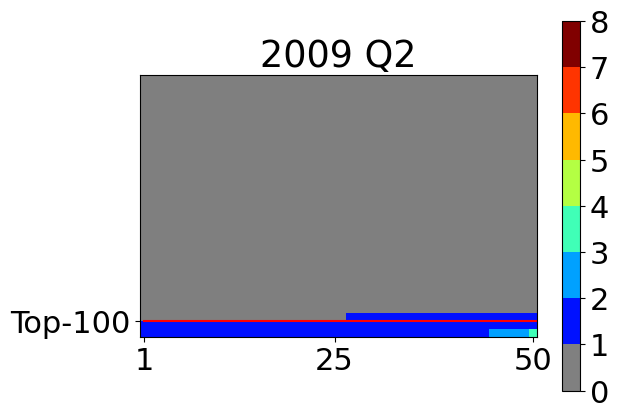

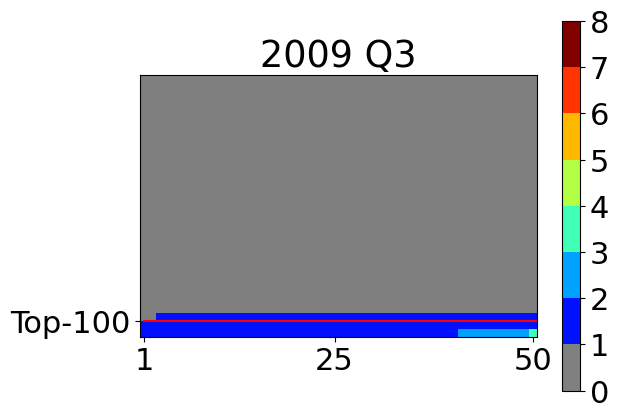

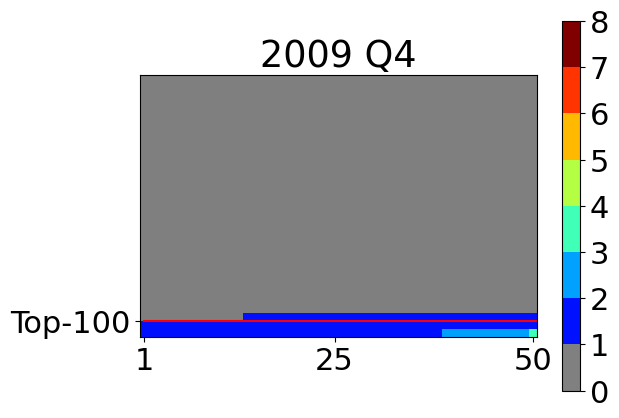

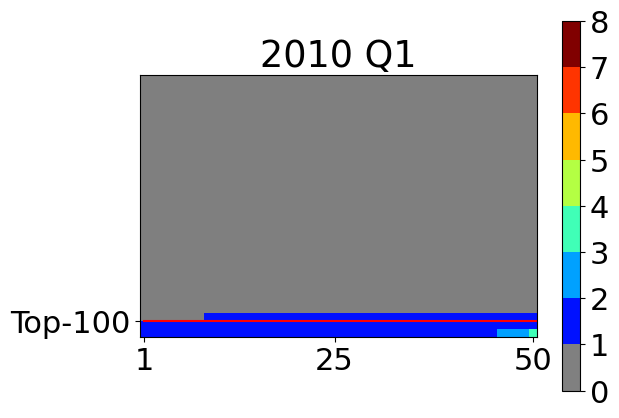

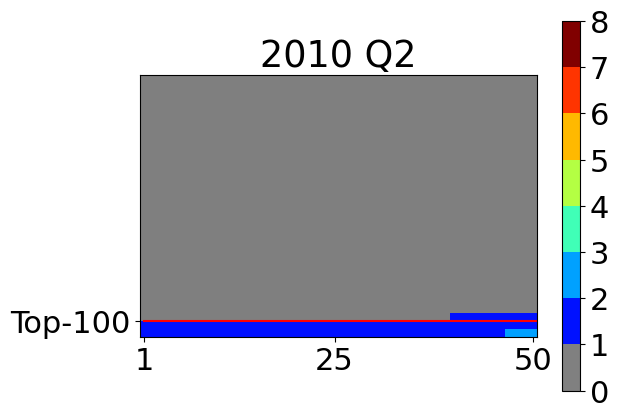

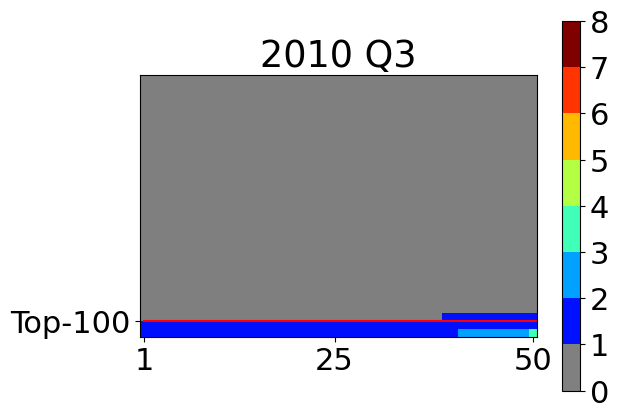

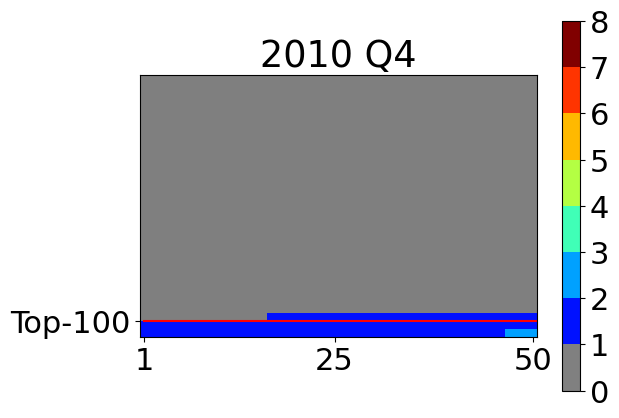

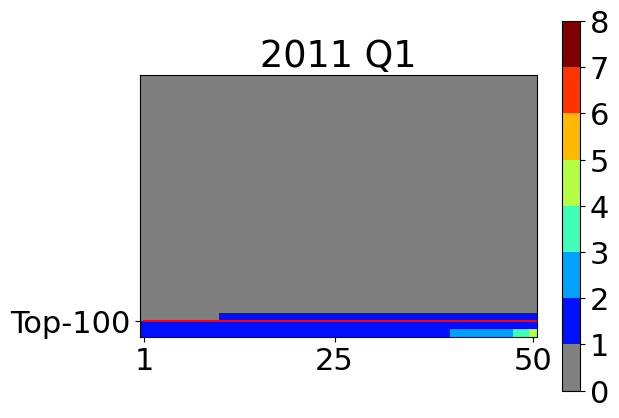

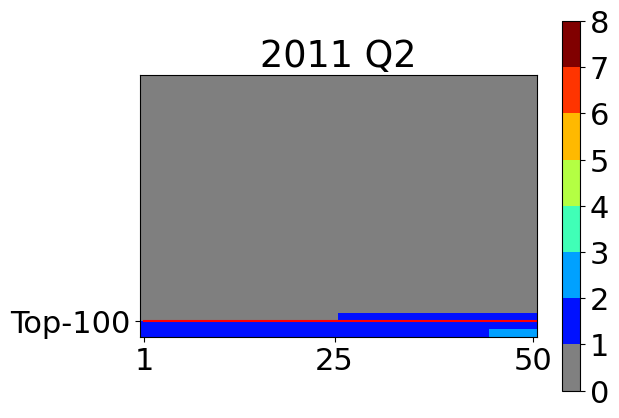

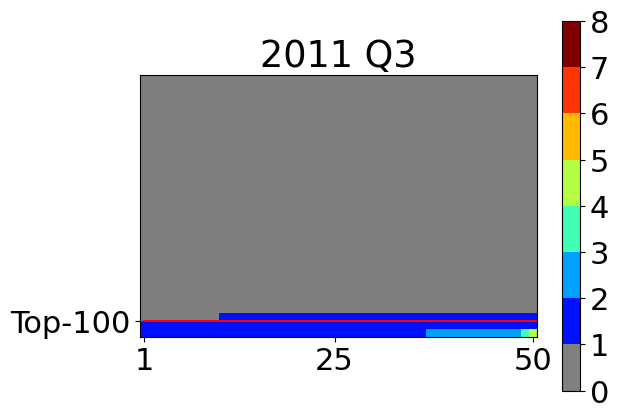

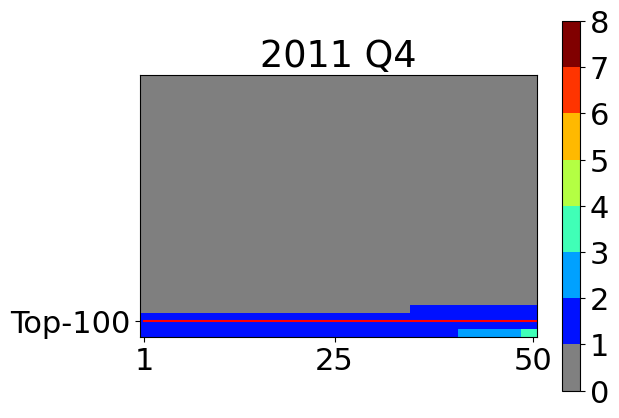

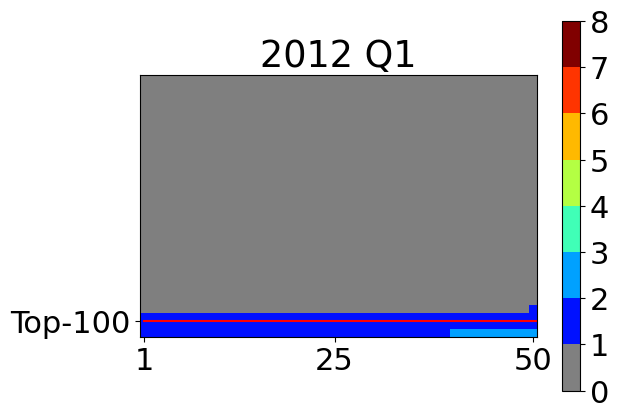

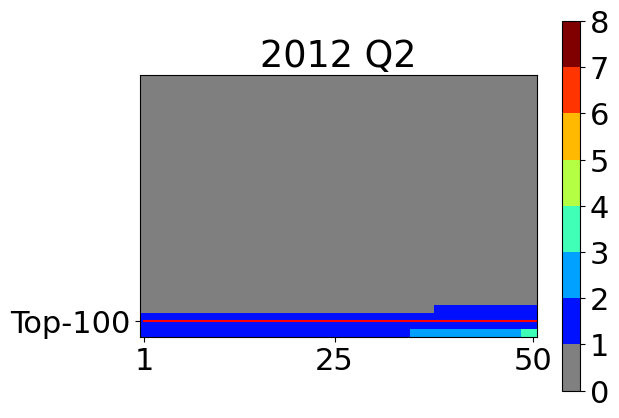

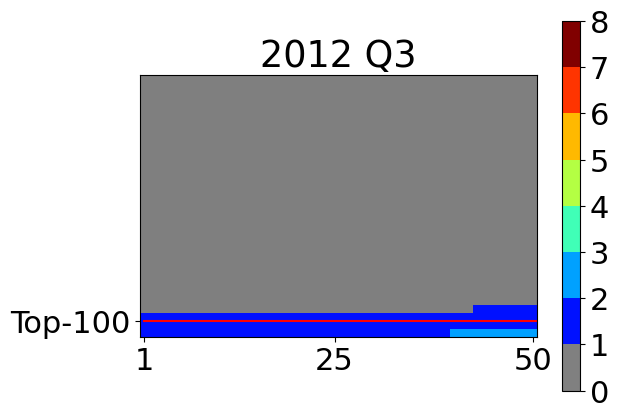

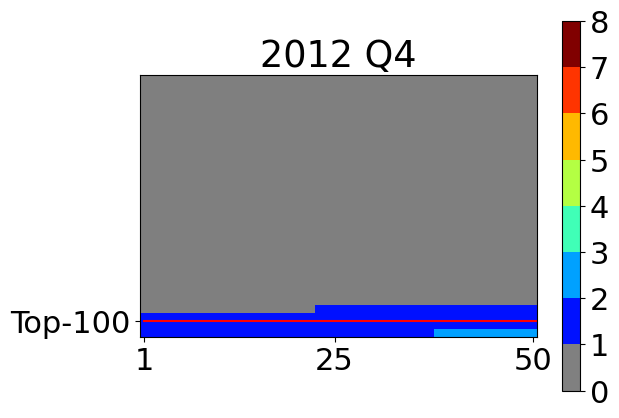

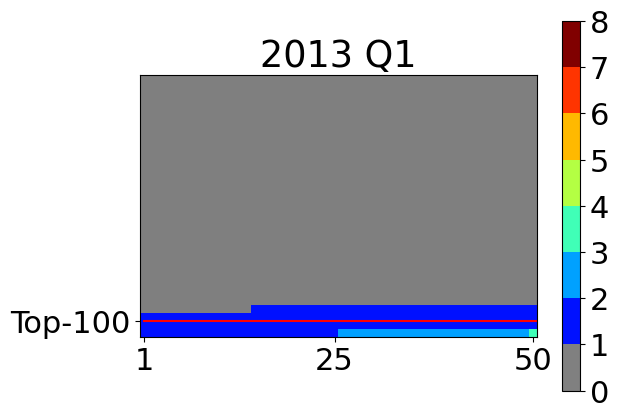

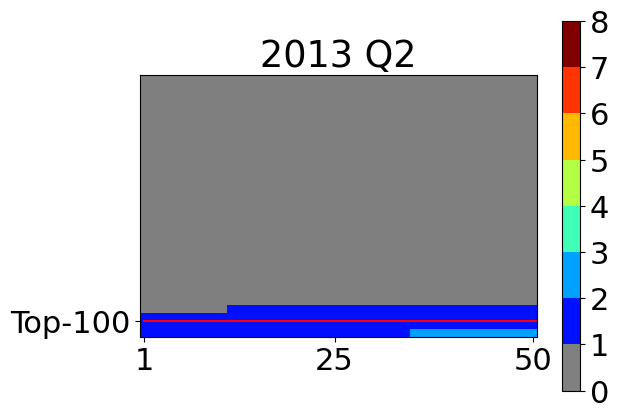

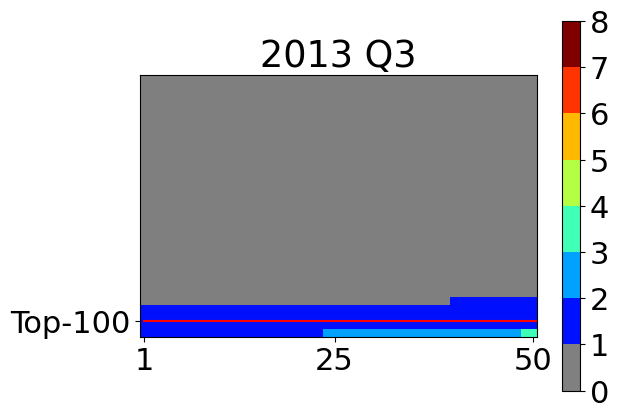

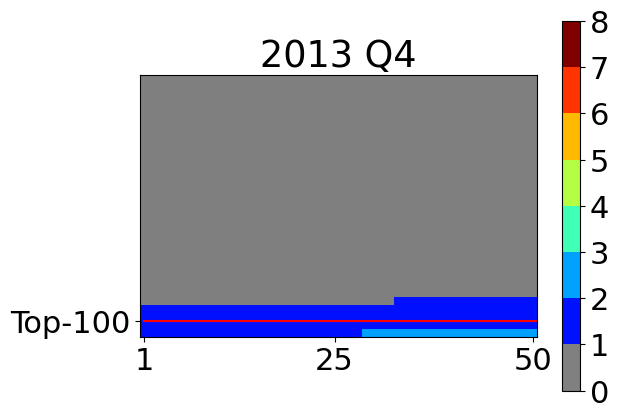

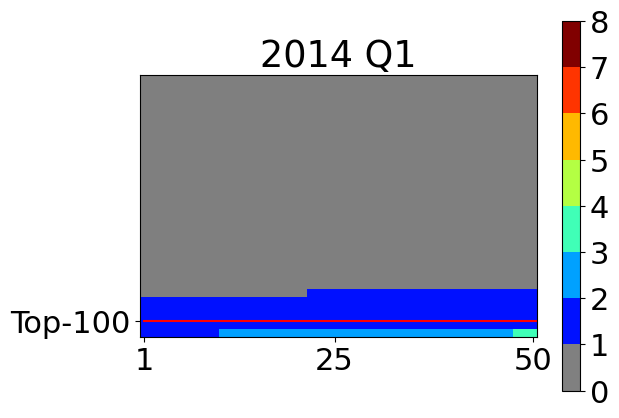

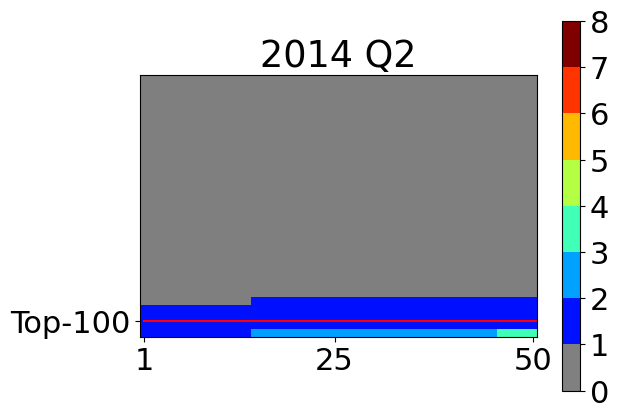

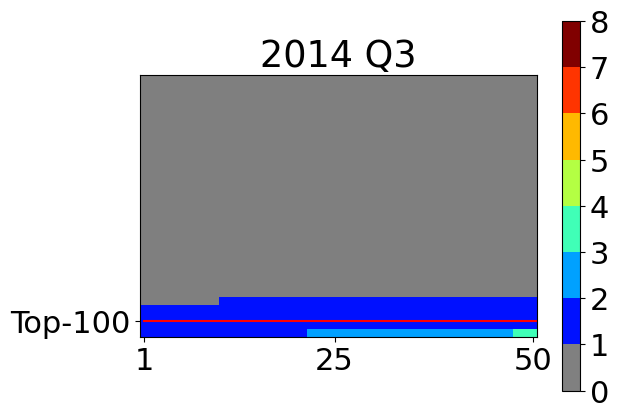

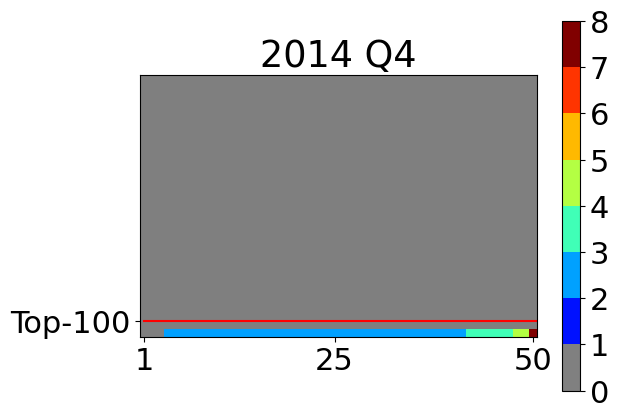

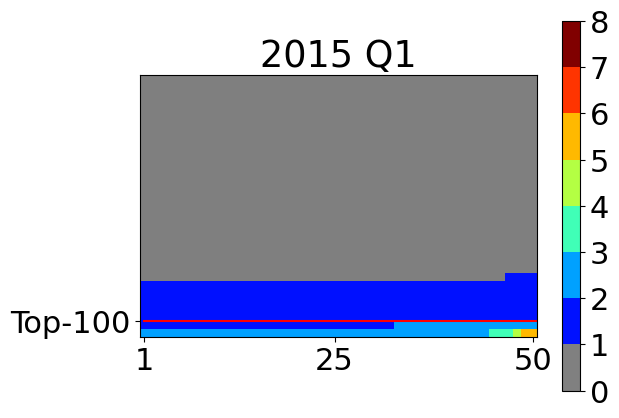

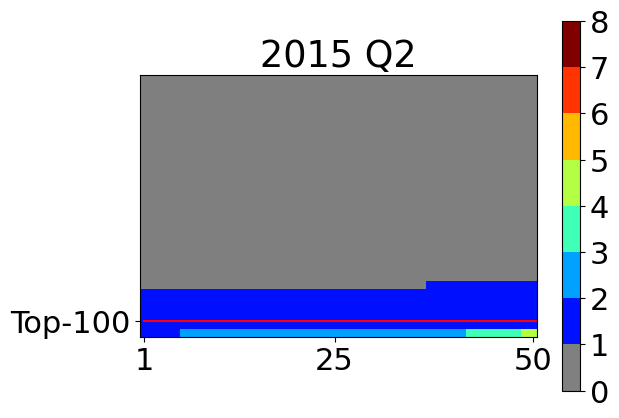

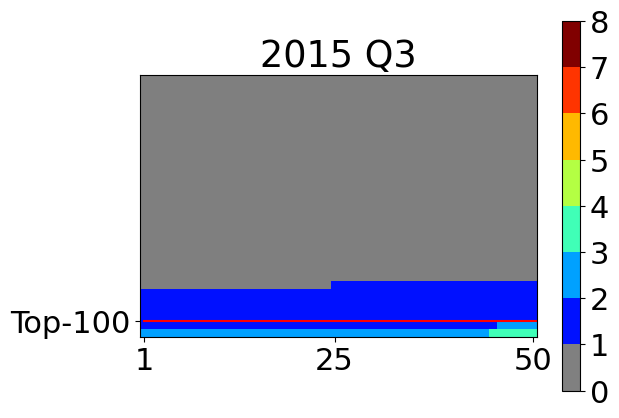

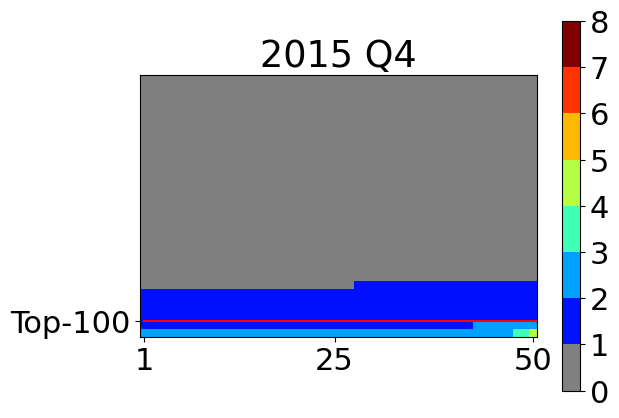

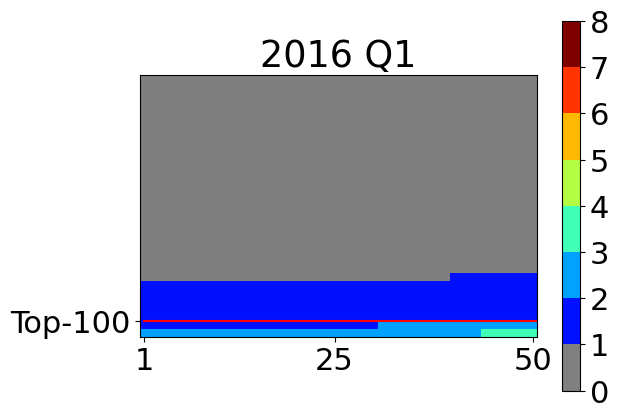

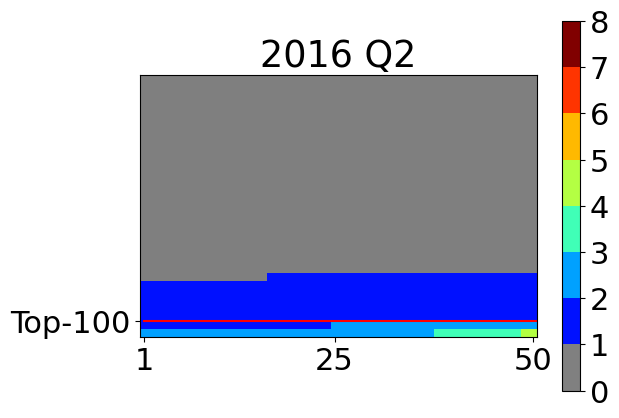

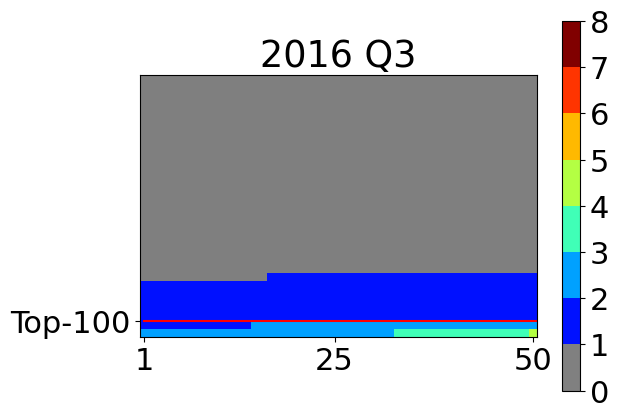

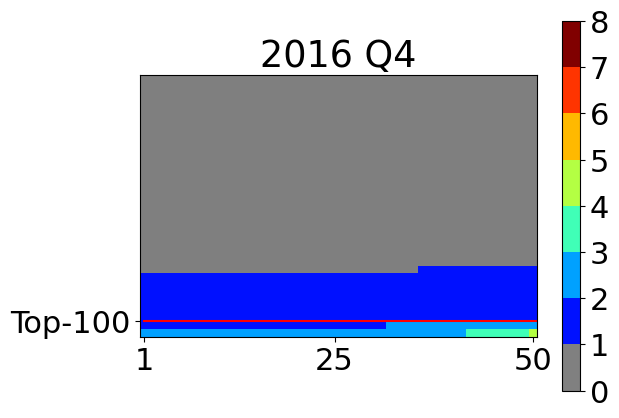

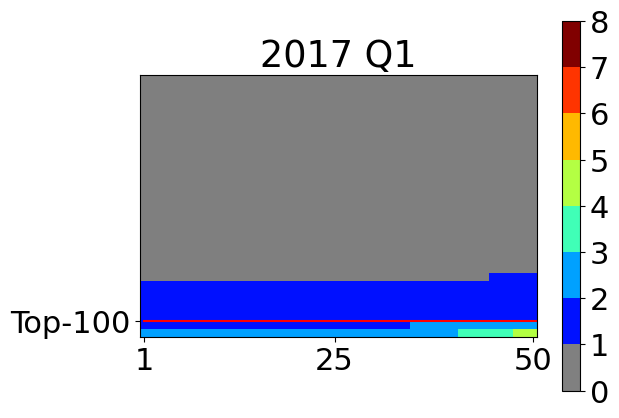

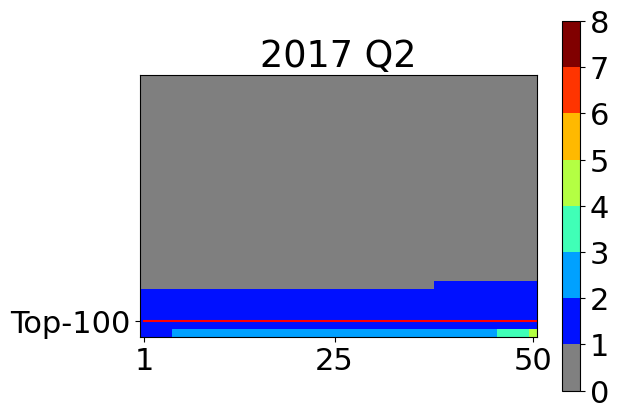

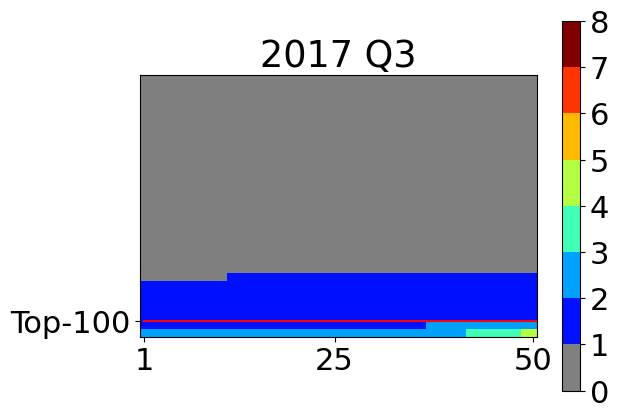

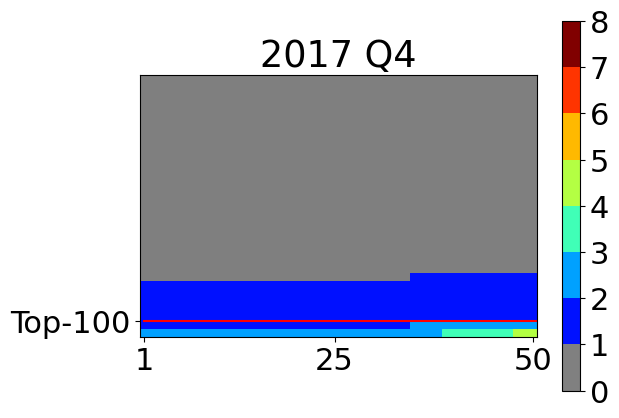

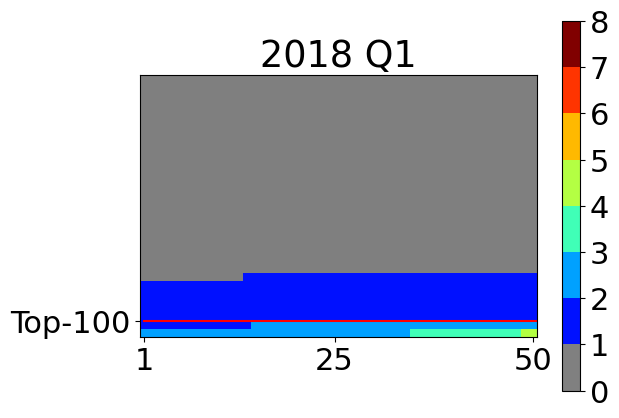

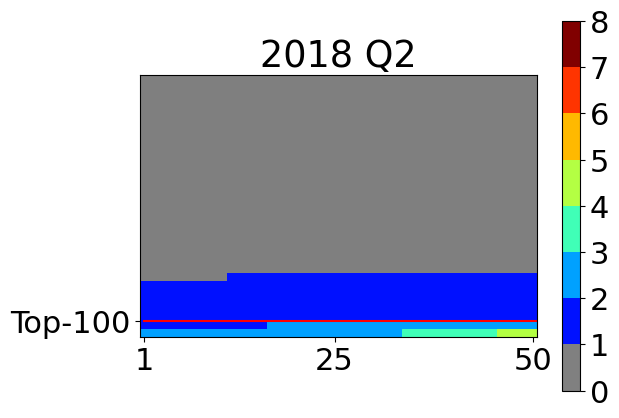

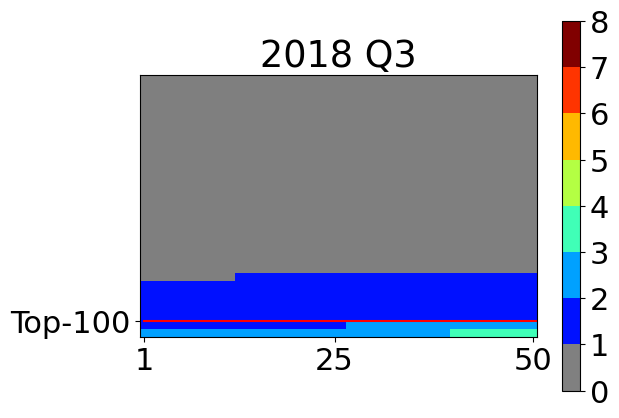

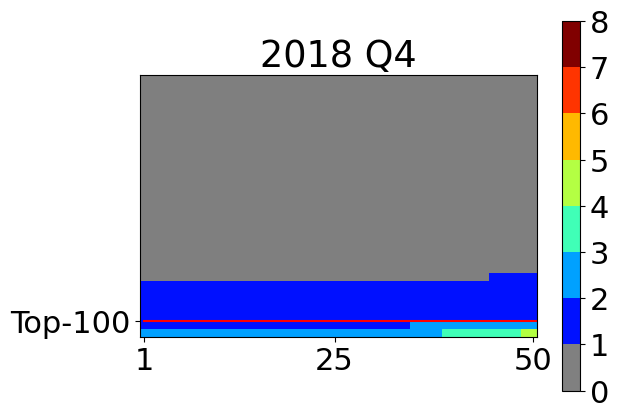

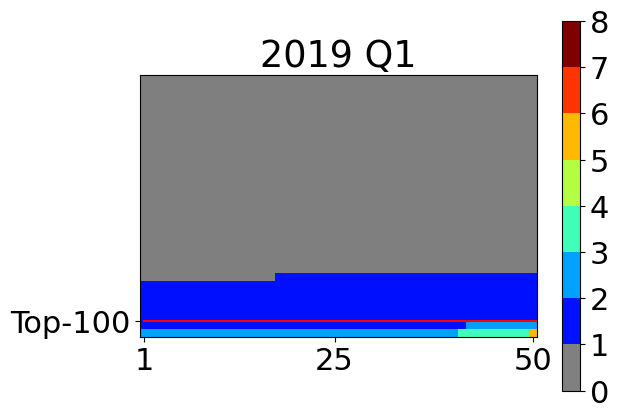

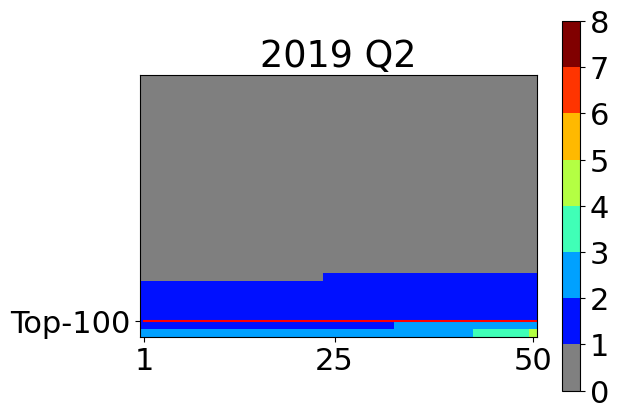

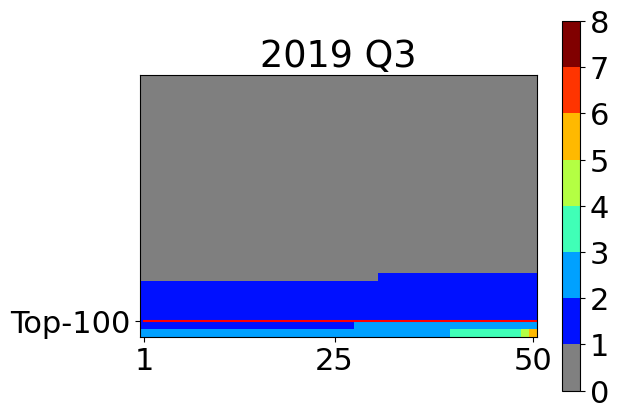

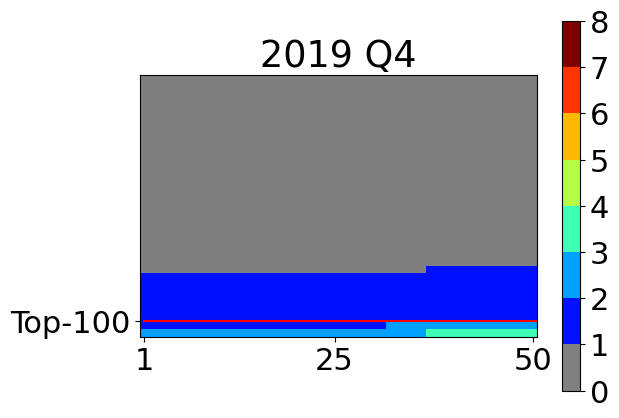

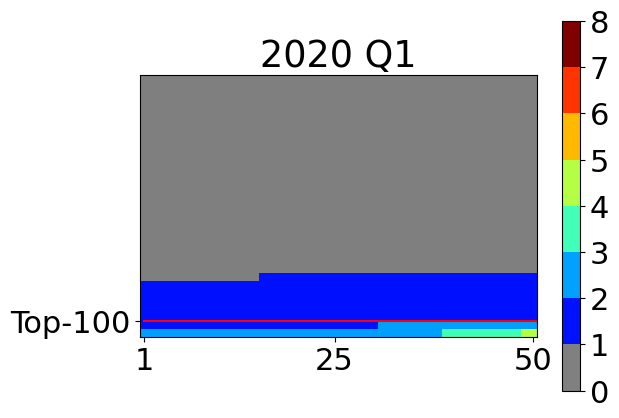

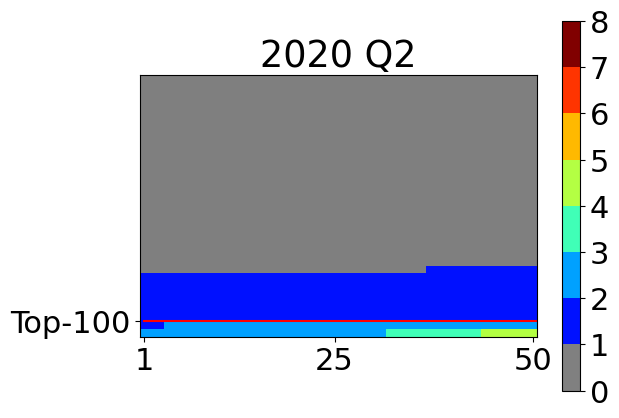

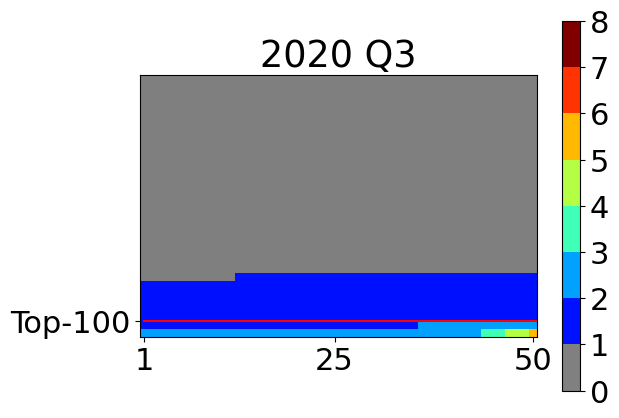

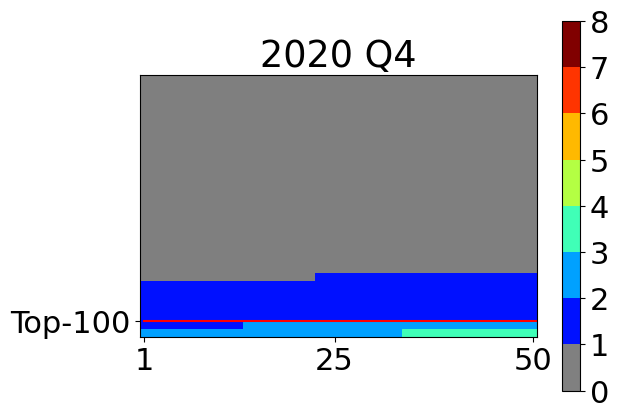

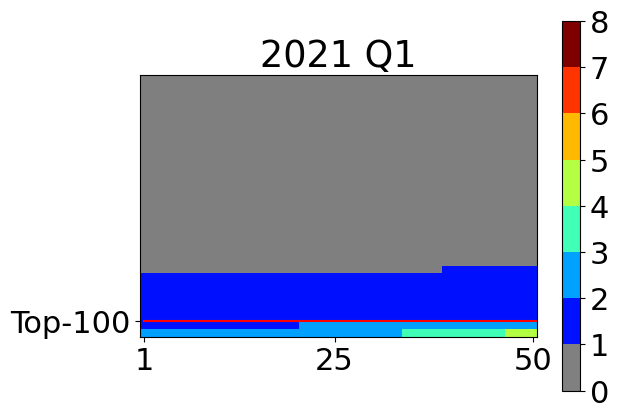

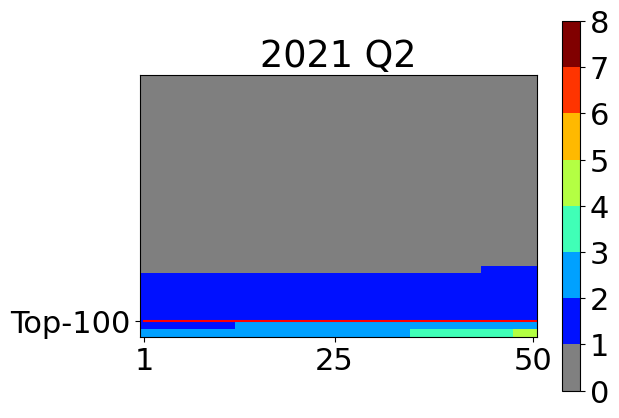

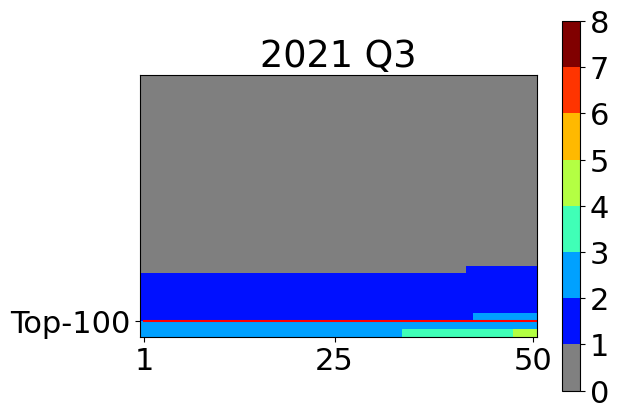

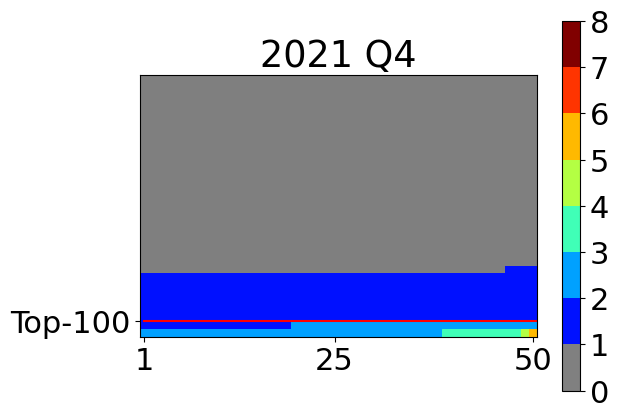

In [80]:
years = range(2000, 2022)
quarters = range(1,5)

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 8, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

for year in years:
    for quarter in quarters:
        deaths = data_gdf[(data_gdf['year']==year)&(data_gdf['quarter']==quarter)]['deaths'].values
        deaths.sort()
        padded_deaths = np.pad(deaths, (30,0))
        
        plt.figure()
        plt.imshow(padded_deaths.reshape((33,50)), cmap=cmap, norm=norm)
        plt.colorbar()
        plt.plot((0,49.5), (30.5,30.5), 'r-')
        plt.xticks([0, 24, 49], labels=[1,25,50])
        plt.yticks([30.5],labels=['Top-100'])
        plt.title(f"{year} Q{quarter}")
        pdf.savefig()
        
pdf.close()

/tmp/ipykernel_31221/953991736.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


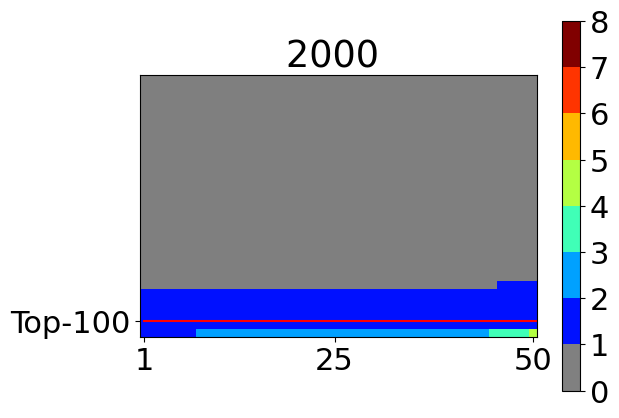

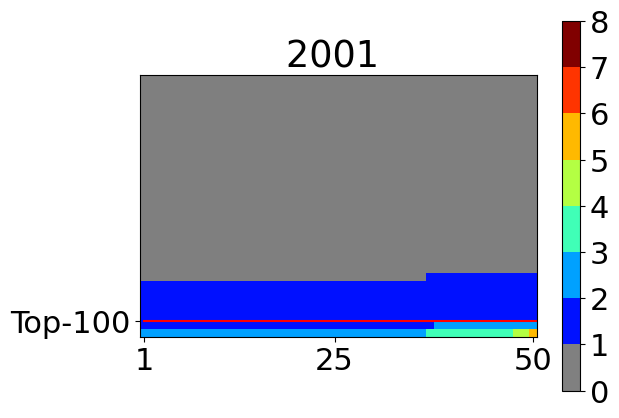

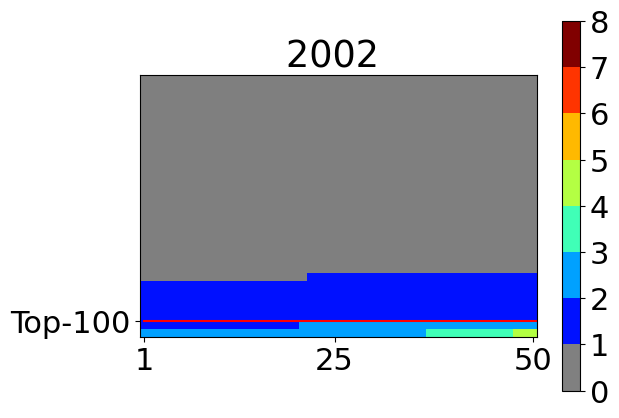

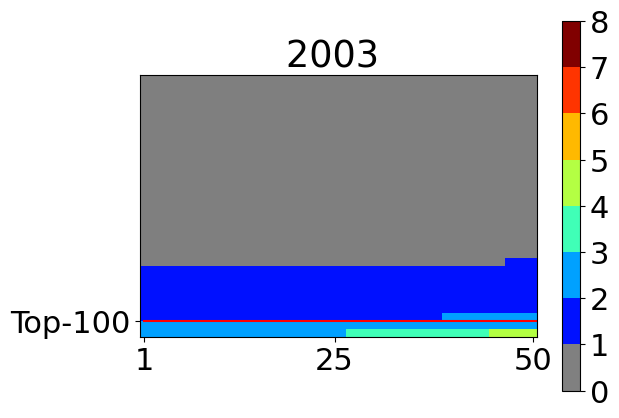

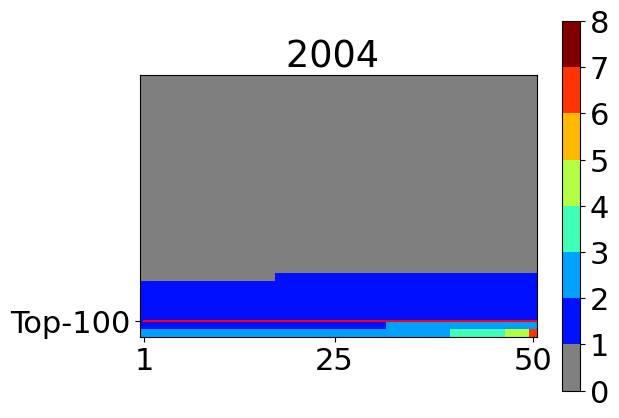

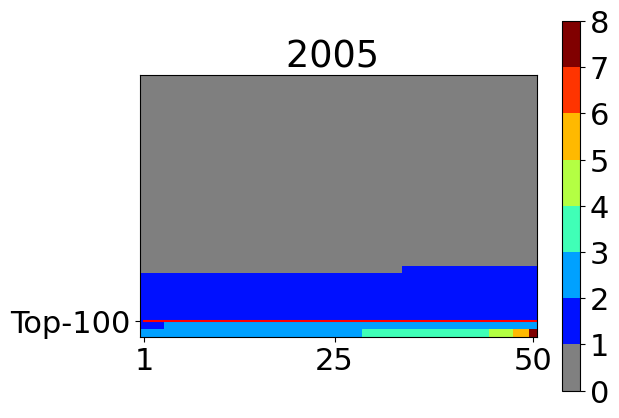

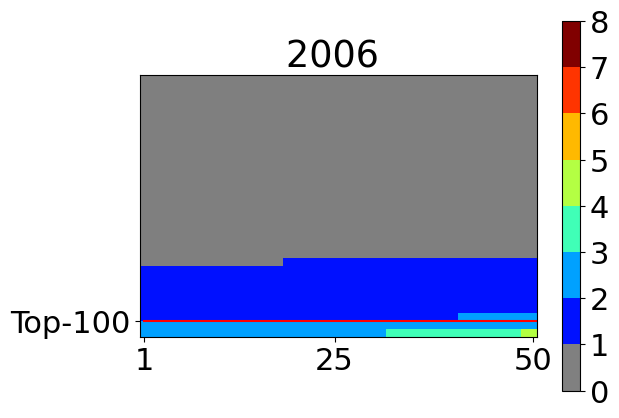

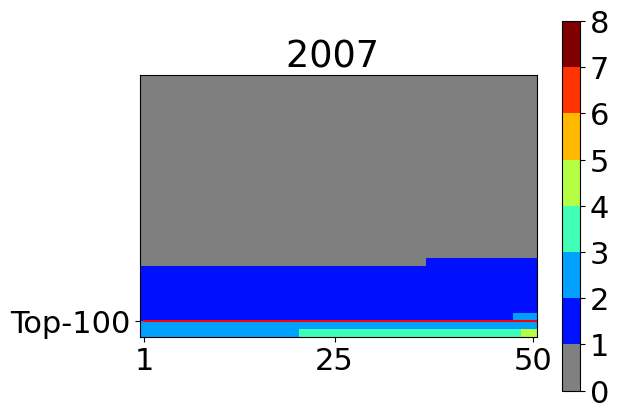

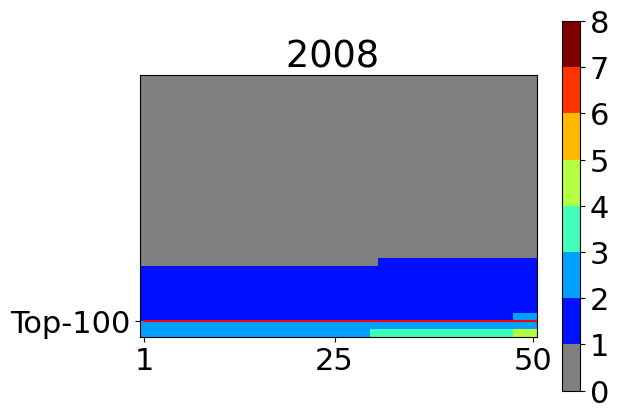

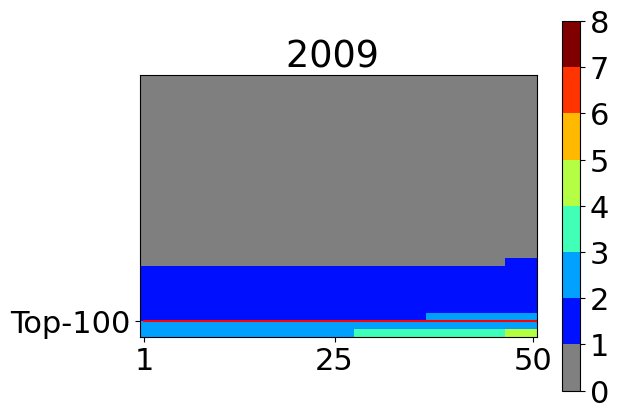

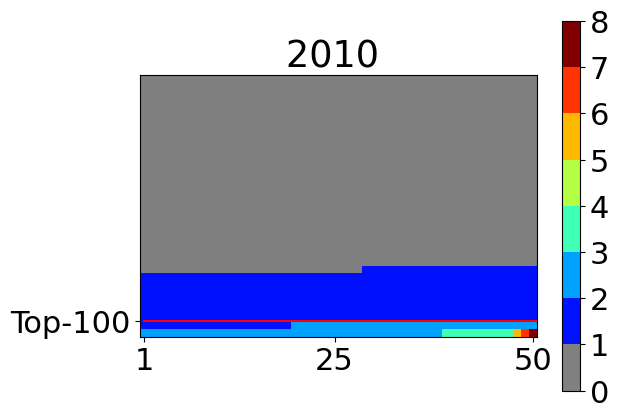

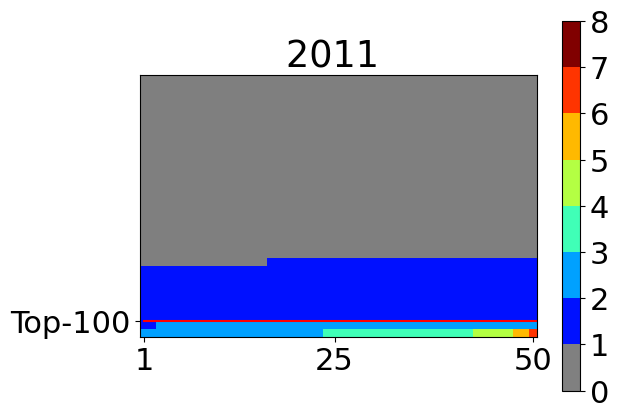

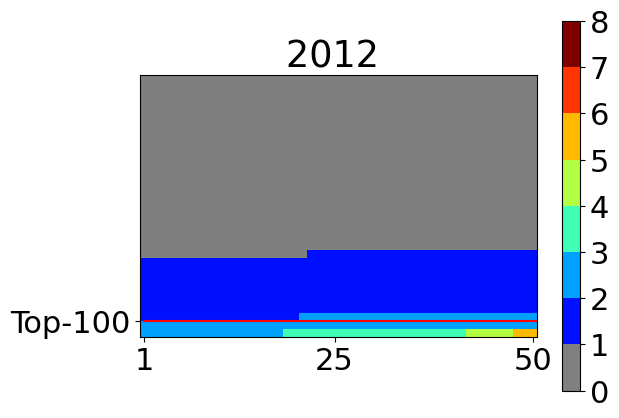

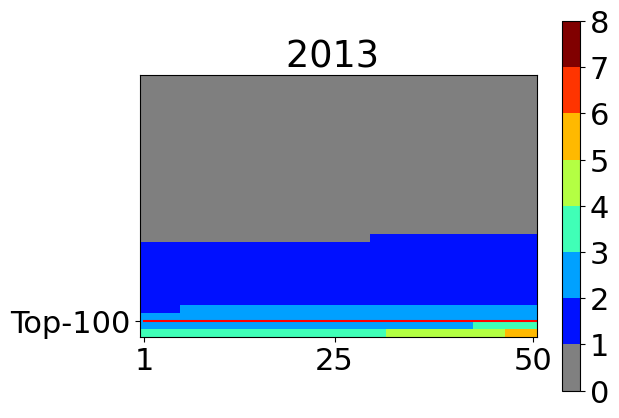

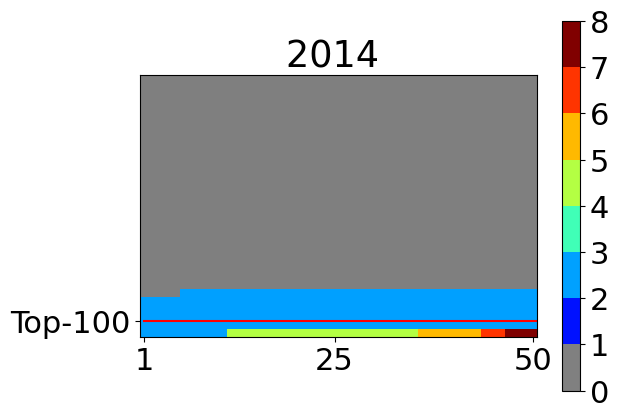

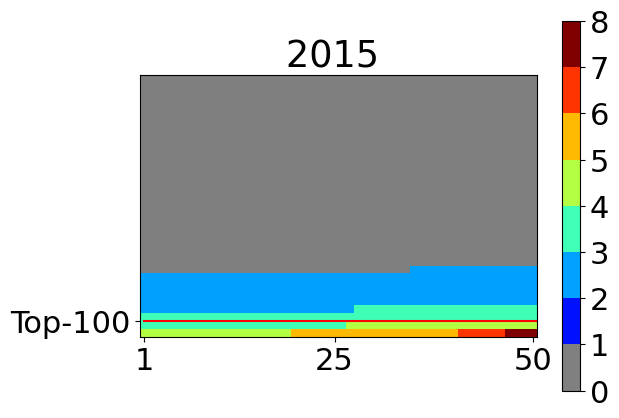

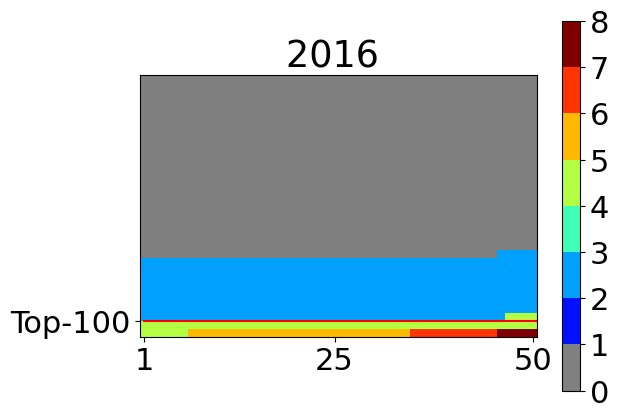

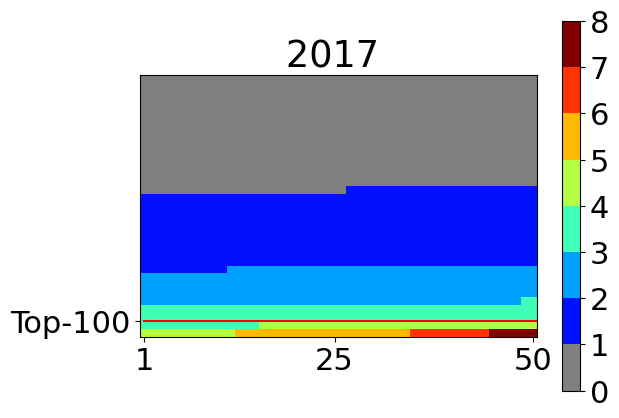

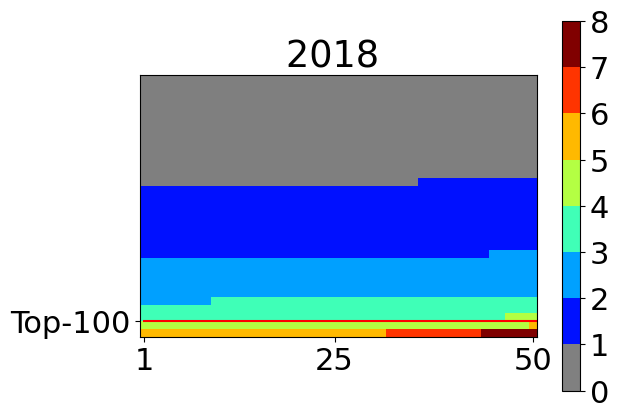

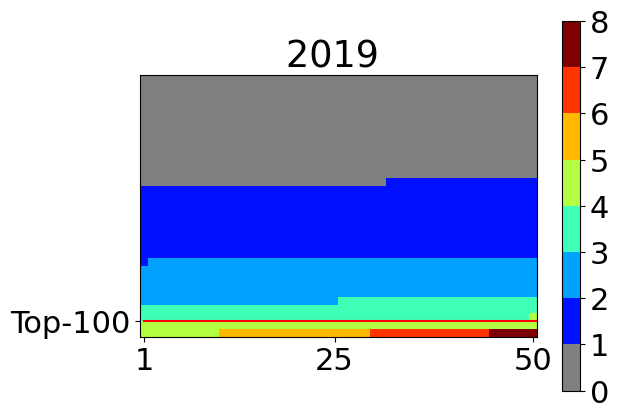

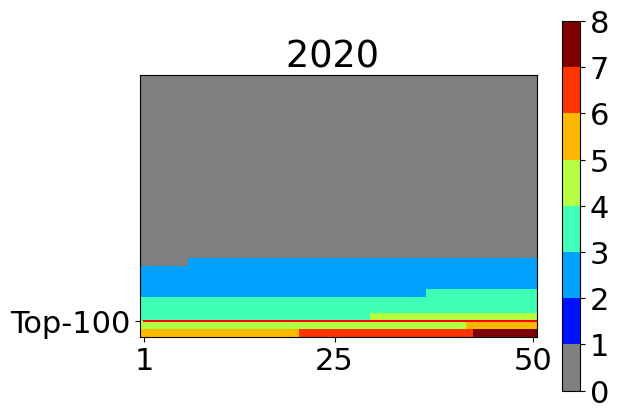

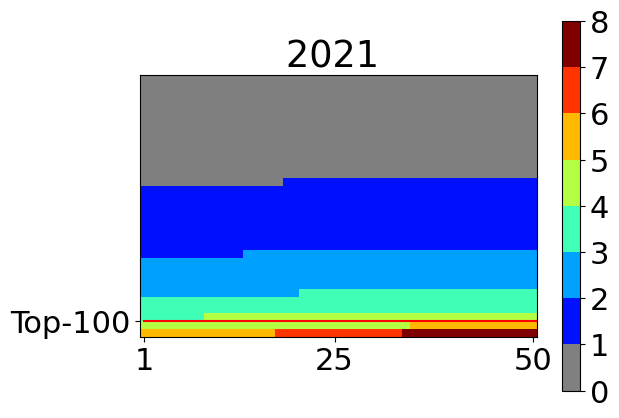

In [81]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output_yr.pdf")

for year in years:
        deaths = data_gdf[(data_gdf['year']==year)].groupby(geography_col).sum()['deaths'].values
        deaths.sort()
        padded_deaths = np.pad(deaths, (30,0))
        
        plt.figure()
        plt.imshow(padded_deaths.reshape((33,50)), cmap=cmap, norm=norm)
        plt.colorbar()
        plt.plot((0,49.5), (30.5,30.5), 'r-')
        plt.xticks([0, 24, 49], labels=[1,25,50])
        plt.yticks([30.5],labels=['Top-100'])
        plt.title(f"{year} ")
        pdf.savefig()
        
pdf.close()

<AxesSubplot: >